In [1]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [2]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/content/gdrive/')

--2022-05-04 23:22:39--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   120MB/s    in 0.7s    

2022-05-04 23:22:40 (120 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b64

In [3]:
!conda env create -f /content/gdrive/MyDrive/generative-audio-inpainting-master/conda_environment.yml
#%%bash
#source activate generative-audio-inpainting
#python
!conda init
!activate generative-audio-inpainting

#/content/gdrive/MyDrive/generative-audio-inpainting-master/generative_audio_inpainting_report.pdf
!pip install /content/gdrive/MyDrive/generative-audio-inpainting-master/libraries
#!pip install mlp
#/content/gdrive/MyDrive/generative-audio-inpainting-master/libraries

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / 

In [4]:
import scipy.io.wavfile as wav
import scipy.signal as sig

import matplotlib.pyplot as plt
import numpy as np

import pickle as pk
import math
import IPython.display as ipd
import os
from sklearn.neural_network import MLPClassifier as mlp
import torch
from torch.utils.data import DataLoader, Dataset
from multiprocessing import Pool

from tqdm import tqdm_notebook as tqdm

from itertools import accumulate
from functools import reduce
import operator as op

fs = 48000

In [5]:
# Most of the questions on how to do stuff can just be done as in: A context encoder for audio inpainting

Some info about the data: 
- 48 samples per ms, so a window of 256 combines the audio of about 5ms into one stroke of pixels (sliding window half each time, so basically 2.5ms per pixel)
- Taking images of width 128 for example would be 340ms per slice, removing 50ms from that is 15%

Inspecting a random file:

In [6]:
speech = '/content/gdrive/MyDrive/generative-audio-inpainting-master/ttsMP3.com_VoiceText_2022-3-4_3_29_56.wav'
fs, audio_time = wav.read(speech)

freqs, times, audio_freqs = sig.stft(audio_time, fs)
times, _audio_time = sig.istft(audio_freqs, fs)

In [7]:
data = audio_freqs.view(np.float32).reshape(129, 2, -1).mean(axis=1)
information = [np.abs(d).mean() for d in data]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
  """Entry point for launching an IPython kernel.


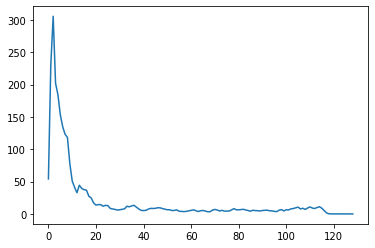

In [8]:
plt.plot(range(129), information)

Trying just the first half of frequencies on bach:

In [9]:
information_acc = np.array(list(accumulate(information)))
information_acc = information_acc / information_acc[-1]

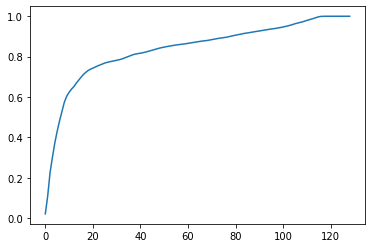

In [10]:
plt.plot(range(129), information_acc)

In [11]:
information_acc[64] # up to 64 contains about 94% off all data (for bach it was 98% even)

0.8733825

So do we really want to take all frequencies, or just everything important, so instead of up till 128, untill 64 for example (this will be 0-12000Hz), apperantly speech data is basically 0-6000Hz (needs a good source), this more than justifyies cutting it off at 12000

In [12]:
fs, audio_time = wav.read(speech)
freqs, times, audio_freqs = sig.stft(audio_time, fs)

audio_freqs[64:] = 0

times, _audio_time = sig.istft(audio_freqs, fs)
ipd.Audio(_audio_time, rate=fs) # unsuprizingly you don't hear a difference, original below

In [13]:
ipd.Audio(audio_time, rate=fs)

This is how a missing stroke of 50ms sounds btw:

In [14]:
ms_per_px = (256 / 48) / 2
remove_px = math.floor(50 / ms_per_px)

fs, audio_time = wav.read(speech)
freqs, times, audio_freqs = sig.stft(audio_time, fs)

audio_freqs[:,1500:1500+remove_px] = 0 

times, _audio_time = sig.istft(audio_freqs, fs)
ipd.Audio(_audio_time, rate=fs)

In [15]:

sys.path.append('/content/gdrive/MyDrive/generative-audio-inpainting-master/libraries')

from mlp.dataset import WAVAudioDS

from mlp.audio import read_monaural_wav, stft

In [16]:
def make_whole(freqs, patch_width):
    mod = freqs.shape[2] % patch_width

    if mod is not 0: 
        padding = torch.zeros((freqs.shape[0], freqs.shape[1], patch_width - mod))
        return torch.cat([freqs, padding], dim=2)
    else:
        return freqs

In [17]:
#files_train = pk.load(open('/content/gdrive/MyDrive/generative-audio-inpainting-master/files/test.pk', 'rb'))#just produces an array of test file NAMES - do same probably
#give path and allow to pull any 
import os
relevant_path = "/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus"
included_extensions = ['wav']
files_train = [fn for fn in os.listdir(relevant_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

#files_train =['/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus/one.wav','/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus/two.wav','/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus/three.wav']
train_freqs = []
max_freqs = 64

for file in files_train[:1000]:
    fs, audio_time = read_monaural_wav(relevant_path+"/"+file)
    _, _, freqs = stft(audio_time, fs)
    
    freqs = torch.from_numpy(freqs.view(np.float32).reshape(129, 2, -1)[:64].transpose(1, 0, 2))
            
    train_freqs.append(freqs)    
    
train_freqs = torch.cat(train_freqs, dim=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead


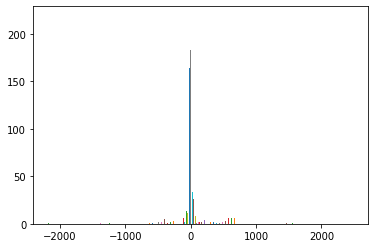

In [18]:
plt.hist(freqs[0], bins=100)
plt.show()

Definitely needs some normalization, but regardless it will probably really like predicting zero

Simple normalization:

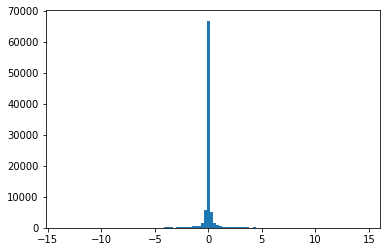

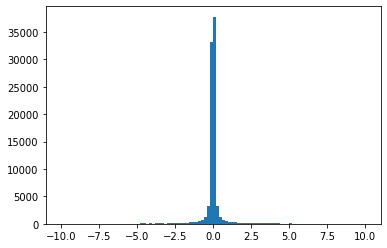

In [19]:
mn = train_freqs.mean()
sd = train_freqs.std()

data = (train_freqs - mn) / sd
points = data.view(-1)

plt.hist(points, bins=100)
plt.show() 

plt.hist(points, bins=100, range=(-10,10))
plt.show() 

Great progres...

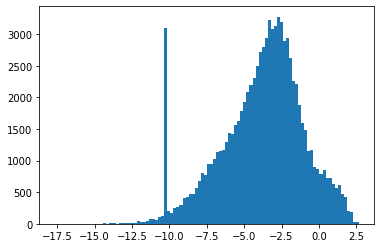

In [20]:
data = (train_freqs - mn) / sd
points = data.view(-1)

plt.hist(np.log(np.abs(points)), bins=100)
plt.show() 

So quite a lot <1, and quite a bit exactly at 0

This is how it sounds if you cut away everything between [-1,1] (so putting everything in the above plot that is to the left of zero in the peak at -15, so most of it):

In [21]:
fs, audio_time = wav.read(speech)

_, _, audio_freqs = sig.stft(audio_time, fs)
audio_freqs = audio_freqs.view(np.float32).reshape(129, 2, -1).transpose(1, 0, 2)
freqs = audio_freqs[0]
freqs = (freqs - mn.item()) / sd.item()
freqs[abs(freqs) < 1] = 0
freqs = freqs * sd.item() + mn.item()
audio_freqs = freqs + audio_freqs[1] * 1j

_, audio_time = sig.istft(audio_freqs, fs)
ipd.Audio(audio_time, rate=fs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Changing the shape of an F-contiguous array by descriptor assignment is deprecated. To maintain the Fortran contiguity of a multidimensional Fortran array, use 'a.T.view(...).T' instead
  after removing the cwd from sys.path.


No real difference, plot becomes

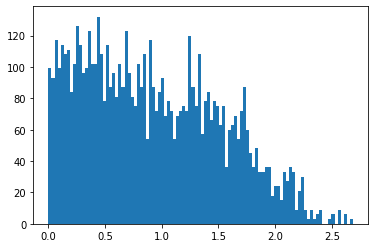

In [22]:
plt.hist(np.log(np.abs(points[np.abs(points) > 1])), bins=100)
plt.show() 

which looks a lot easier for the AI to do predictions on :), although we did loose the sign which is definitely not OK. So options are a different normalization, or giving sign information to the NN sepperately

Another option for normalziation is to normalize each frequency seperatly, but this would destroy the meaning of the actual numbers when compared across frequencies, which might make fixing it more difficult.

We can also train a net on the magnitude and the phase, those normalize well:

In [23]:
magnitude = torch.norm(train_freqs, dim=0).view(-1)
phase = torch.atan(train_freqs[1] / train_freqs[0]).view(-1)

filtered_magnitude = magnitude[magnitude != 0.]
filtered_phase = phase[magnitude != 0.]

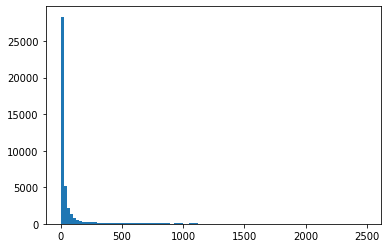

In [24]:
plt.hist(filtered_magnitude, bins=100)
plt.show()

In [25]:
from mlp.normalization import norm_mag, norm_phase

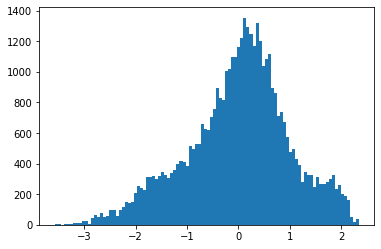

In [26]:
log_magnitude = torch.log(filtered_magnitude)
normalised_magnitude = (log_magnitude - torch.mean(log_magnitude)) / torch.std(log_magnitude)

plt.hist(normalised_magnitude, bins=100)
plt.show()

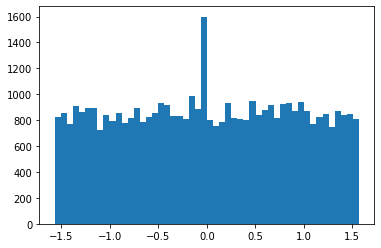

In [27]:
plt.hist(filtered_phase, bins=50)
plt.show()

well if that doesn't look super nice to learn that I don't know what :) polar coords it is

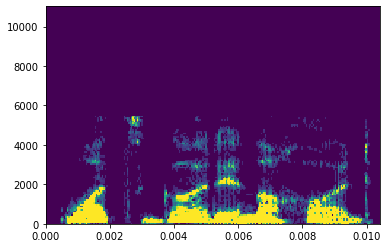

In [28]:
import scipy.io.wavfile as wav
import scipy.signal as sig

import matplotlib.pyplot as plt
import numpy as np

import IPython.display as ipd

speech = '/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus/two.wav'
fs, audio_time_orig = wav.read(speech) # actually a stereo file, so contains data for the left and right speaker
fs
audio_time_orig = np.array(audio_time_orig)
#audio_time_orig[fs // 2:fs // 2 + fs // 0]# = 0 #removes patch
freqs, times, audio_freqs = sig.stft(audio_time_orig, fs) # using just the audio from the left speaker
std = audio_freqs.std()
audio_freqs[64:] = 0
audio_freqs[abs(audio_freqs) < 25] = 0
times, audio_time = sig.istft(audio_freqs, fs)
ipd.Audio(audio_time, rate=fs)
def show_spectra(i, size, f, t, z, imax):
    part = slice(i*size, (i+1)*size)
    plt.pcolormesh(t[part], f, np.abs(z[:,part]), vmin=0, vmax=imax)

def filter_start(freqs, cutoff=25):
    mags = np.abs(freqs).mean(axis=0)
    start = 0
    end = -1
    
    while mags[start] < 25:
        start += 1
    
    while mags[end] < 25:
        end -= 1
    
    return start, end

times[-515]
filter_start(audio_freqs)
show_spectra(0, len(audio_freqs[0]), freqs, times, audio_freqs, 250)
ipd.Audio(audio_time, rate=fs)

In [29]:
import os
import numpy as np
import math
import itertools
import time
import datetime
import sys
import pickle
from multiprocessing import Pool
import resource
from tqdm import tqdm

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from models.pix2pix import *
from models.unet import *
from mlp import audio
from mlp import normalization
from mlp import utils as mlp
from mlp.dataset import WAVAudioDS, PolarPreprocessing

%load_ext autoreload

%matplotlib inline
%autoreload

epoch = 0 # epoch to start training from
n_epochs = 30 # number of epochs of training
dataset_name = 'VCTK' # name of the dataset
batch_size = 4 # size of the batches
lr = 0.0002 # adam: learning rate
b1 = 0.5 # adam: decay of first order momentum of gradient
b2 = 0.999 # adam: decay of first order momentum of gradient
decay_epoch = 100 # epoch from which to start lr decay
n_cpu = 4 # number of cpu threads to use during batch generation
img_height = 64 # size of image height
img_width = 64 # size of image width
channels = 1 # number of image channels
sample_interval = 100 # interval between sampling of images from generators
checkpoint_interval = 1 # interval between model checkpoints


cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resource.setrlimit(resource.RLIMIT_NOFILE, (4096, resource.getrlimit(resource.RLIMIT_NOFILE)[1]))

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, img_height//2**4, img_width//2**4)
class UNet(nn.Module):
    def __init__(self, leaky_relu=False, dropout=0.0):
        super(UNet, self).__init__()
        self.inc = inconv(1, 64, leaky_relu=leaky_relu)
        self.down1 = down(64, 128, leaky_relu=leaky_relu)
        self.down2 = down(128, 256, leaky_relu=leaky_relu)
        self.down3 = down(256, 512, leaky_relu=leaky_relu, dropout=dropout)
        self.down4 = down(512, 512, leaky_relu=leaky_relu, dropout=dropout)
        self.up1 = up(1024, 256, bilinear=True, leaky_relu=leaky_relu, dropout=dropout)
        self.up2 = up(512, 128, bilinear=True, leaky_relu=leaky_relu, dropout=dropout)
        self.up3 = up(256, 64, bilinear=True, leaky_relu=leaky_relu)
        self.up4 = up(128, 64, bilinear=True, leaky_relu=leaky_relu)
        self.outc = outconv(64, 1)


    def forward(self, x):#forward to generator
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [30]:
pretrained_generator = UNet(leaky_relu=False, dropout=0.0).to(device)
generator = UNet(leaky_relu=True, dropout=0.5).to(device)
discriminator = Discriminator(in_channels=channels).to(device)

if cuda:
    generator = generator.cuda()
    pretrained_generator = pretrained_generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

if cuda:
    pretrained_generator.load_state_dict(torch.load('/content/gdrive/MyDrive/generative-audio-inpainting-master/files/32_64_model_final.pt'))
else:
    pretrained_generator.load_state_dict(torch.load('/content/gdrive/MyDrive/generative-audio-inpainting-master/files/32_64_model_final.pt', map_location='cpu'))
    
if epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load('generator_%d.pth' % (epoch)))
    discriminator.load_state_dict(torch.load('discriminator_%d.pth' % (epoch)))
else:
    # Initialize weights
    generator.apply(weights_init_normal)
    if cuda:
        generator.load_state_dict(torch.load('/content/gdrive/MyDrive/generative-audio-inpainting-master/files/32_64_model_final.pt'))
    else:
        generator.load_state_dict(torch.load('/content/gdrive/MyDrive/generative-audio-inpainting-master/files/32_64_model_final.pt', map_location='cpu'))
    discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))



In [31]:
fs = 48000
bs = batch_size
stroke_width = 32
patch_width = img_width
patch_height = img_height
nperseg = 256


#train_files = pickle.load(open("/content/gdrive/MyDrive/generative-audio-inpainting-master/files/train.pk", "rb"))[:1]
import os
relevant_path = "/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus/datasets/90s_dance_mixes"
included_extensions = ['wav']
train_files = [relevant_path+"/"+fn for fn in os.listdir(relevant_path)
              if any(fn.endswith(ext) for ext in included_extensions)]
relevant_path = "/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus/datasets/90s dance validation"
included_extensions = ['wav']
val_files = [relevant_path+"/"+fn for fn in os.listdir(relevant_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

#for file in val_files[len(val_files)-1]:
#  val_files[file] = relevant_path+"/"+val_files[file] 
print(val_files)

#val_files = pickle.load(open("/content/gdrive/MyDrive/generative-audio-inpainting-master/files/valid.pk", "rb"))[:1]
#val_files = ''.join(val_files)
stroke_mask = mlp.build_stroke_purge_mask(patch_width, patch_height, stroke_width, fs, channels=1)
stroke_mask_not = ~stroke_mask

purge_mask = stroke_mask.float()
keep_mask = stroke_mask_not.float().to(device)

preprocess = PolarPreprocessing(
    normalization.norm_mag, 
    normalization.norm_phase, 
    patch_width,#to return the patchwidth
    patch_height,
    include_phase=False
)
#''.join(sentence)

torch.multiprocessing.set_sharing_strategy('file_system')
with Pool(1) as p:
    ds_valid = WAVAudioDS(files=val_files, mk_source=lambda x: x * purge_mask, preprocess=preprocess, 
                          patch_width=patch_width, proc_pool=p, nperseg=256, random_patches=False) 
    relevant_path = "/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus/datasets/90s_dance_mixes"
    ds_train = WAVAudioDS(train_files, mk_source=lambda x: x * purge_mask, preprocess=preprocess, 
                          patch_width=patch_width, proc_pool=p, nperseg=256, random_patches=True) 
        
val_dataloader = DataLoader(ds_valid, batch_size=bs, num_workers=4, shuffle=False)
dataloader = DataLoader(ds_train, batch_size=bs, num_workers=4, shuffle=False)



['/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus/datasets/90s dance validation/1.wav', '/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus/datasets/90s dance validation/2.wav', '/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus/datasets/90s dance validation/3.wav', '/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus/datasets/90s dance validation/4.wav', '/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus/datasets/90s dance validation/30.wav', '/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus/datasets/90s dance validation/31.wav', '/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus/datasets/90s dance validation/32.wav', '/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus/datasets/90s dance validation/33.wav', '/content/gdrive/MyDrive/generative-audio-inpainting-master/files/corpus/datasets/90s dance validation/34.w

100%|██████████| 10/10 [00:00<00:00, 5184.55it/s]
/content/gdrive/MyDrive/generative-audio-inpainting-master/libraries/mlp/dataset.py:106: ComplexWarning: Casting complex values to real discards the imaginary part
  return torch.from_numpy(freqs.reshape(129, 2, -1)[:max_freqs].transpose(1, 0, 2).astype(np.float32))
100%|██████████| 30/30 [00:00<00:00, 6007.02it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [32]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

def sample_images(epoch, batches_done):
    """Saves a sample from the validation set"""
    imgs = next(iter(val_dataloader))
    real_A = Variable(imgs[0].type(Tensor))
    real_B = Variable(imgs[1].type(Tensor))


    recon_B = generator(real_A.to(device)).detach()
    recon_B = real_A + stroke_mask_not.float()*recon_B
    recon_B_old = pretrained_generator(real_A.to(device)).detach()
    recon_B_old = real_A + stroke_mask_not.float()*recon_B_old
    
    img_sample = torch.cat((real_A.detach(), recon_B.detach(), recon_B_old.detach(), real_B.detach()), -2)
    torch.save(img_sample, '%s_%s.pt' % (epoch, batches_done))
    if batches_done == 4500:
            print(real_A.shape)
            print(recon_B.shape)
            print(recon_B_old.shape)
            print(real_B.shape)


In [33]:
prev_time = time.time()
results = []
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(dataloader):
        # Model inputs
        real_A = Variable(batch[0].type(Tensor)) # Gap
        real_B = Variable(batch[1].type(Tensor)) # Original (No gap)
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        fake_B = generator(real_A)
        pred_fake = discriminator(fake_B, real_A)
        loss_GAN = criterion_GAN(pred_fake, valid)
        
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_B, real_B)
        
        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_B, real_A)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach(), real_A)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s" %
                                                        (epoch, n_epochs,
                                                        i, len(dataloader),
                                                        loss_D.item(), loss_G.item(),
                                                        loss_pixel.item(), loss_GAN.item(),
                                                        time_left))
        results.append((epoch, loss_D.item(), loss_G.item(), loss_pixel.item(), loss_GAN.item()))
        with open('results.pkl', 'wb') as fp:
            pickle.dump(results, fp)

        # If at sample interval save image
        if batches_done % sample_interval == 0:
            sample_images(epoch, batches_done)


    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), 'generator_%d.pth' % (epoch))
        torch.save(discriminator.state_dict(), 'discriminator_%d.pth' % (epoch))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 29/30] [Batch 145/146] [D loss: 0.010056] [G loss: 12.802478, pixel: 0.116956, adv: 1.106860] ETA: 0:00:01.052482

In [34]:
#from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
ipd.Audio(audio_time, rate=fs)

torch.Size([4, 1, 256, 64])
[64:127] tensor([[662.8700, 621.1084, 600.4645,  ..., 713.0490, 901.6012, 825.1686],
        [611.9656, 540.6089, 546.9127,  ..., 688.6769, 808.0235, 825.2083],
        [592.9332, 634.0351, 562.9668,  ..., 744.6792, 624.4268, 749.2153],
        ...,
        [538.5981, 425.1696, 476.3442,  ..., 315.3061, 446.1816, 434.8012],
        [409.4690, 452.7336, 369.2988,  ..., 396.3787, 379.9458, 236.6136],
        [444.3257, 461.5742, 366.0662,  ..., 405.2241, 414.2504, 396.3080]])


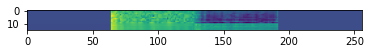

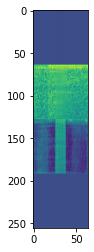

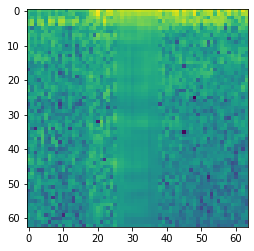

sample tensor(2.1022)


In [36]:
import torch

sample_img = torch.load('/content/29_4300.pt')
print(sample_img.shape)
print("[64:127]",sample_img[3][0][64:127])
reshape = np.swapaxes(sample_img[3][0],0,1)
plt.imshow(reshape[16:31])
plt.show()
plt.imshow(sample_img[3][0])
plt.show()
plt.imshow(sample_img[3][0][64:127])
plt.show()


print("sample",sample_img[3][0][1][1])

#torch.tensor([[1., -1.], [1., -1.]])

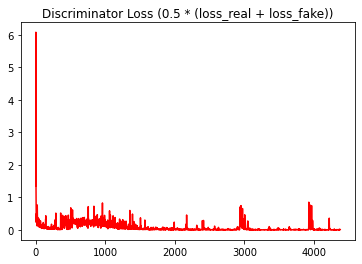

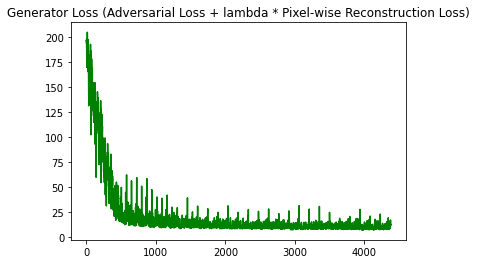

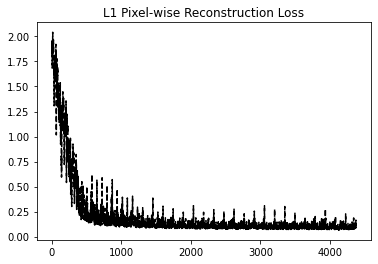

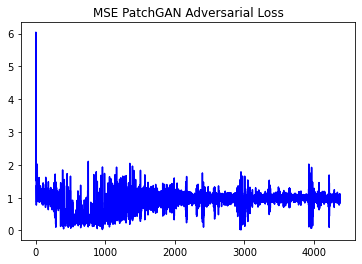

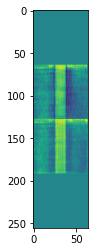

In [37]:

import pickle
import torch
from matplotlib import pyplot as plt
import numpy as np


%matplotlib inline

with open ('results.pkl', 'rb') as fp:
    res = pickle.load(fp)

sample_img = torch.load('0_0.pt')

epoch = [x[0] for x in res]
loss_D = [x[1] for x in res]
loss_G = [x[2] for x in res]
loss_pixel = [x[3] for x in res]
loss_GAN = [x[4] for x in res]

plt.plot(range(len(res)), loss_D, 'r-')
plt.title('Discriminator Loss (0.5 * (loss_real + loss_fake))')
plt.show()

#%% [code]
plt.plot(range(len(res)), loss_G, 'g-')
plt.title('Generator Loss (Adversarial Loss + lambda * Pixel-wise Reconstruction Loss)')
plt.show()

#%% [code]
plt.plot(range(len(res)), loss_pixel, 'k--')
plt.title('L1 Pixel-wise Reconstruction Loss')
plt.show()

#%% [code]
plt.plot(range(len(res)), loss_GAN, 'b-')
plt.title('MSE PatchGAN Adversarial Loss')
plt.show()

#%% [code]
plt.imshow(sample_img[3][0])
plt.show()


dozen files, similar and distinct sets. 



In [38]:
from typing import Any
#from scipy import signal
sample_rate=976


_, reconstructed = sig.istft(sample_img[3][0][0:63], sample_rate)
print(reconstructed.size)
rounded_reconstructed = np.rint(reconstructed).astype(np.int16)
ipd.Audio(rounded_reconstructed,rate=428)

test_file = os.path.join('/content/drive/MyDrive/generative-audio-inpainting-master/files/corpus/datasets/origionalTest2.wav')
wav.write(test_file, 428, rounded_reconstructed)

3906


In [39]:
testOut = '/content/drive/MyDrive/generative-audio-inpainting-master/files/corpus/datasets/origionalTest.wav'
fs, audio_time = wav.read(testOut)
ipd.Audio(audio_time, rate=fs)